# PCA Analysis of XGBoost Model with Transformer Embeddings

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report
from sklearn.utils import shuffle

from utils.data_utils import load_data
from utils.embeddings import EmbeddingExtractor

# Set random seed
RANDOM_STATE = 42
SAMPLE_SIZE = 10000
DEFAULT_PCA_COMPONENTS = 20
EMBEDDING_MODEL_NAME = "BAAI/bge-m3"

# disable "This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable."
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"


## Load Data and Extract Embeddings

We load the pre-cleaned data, and extract text embeddings from the `chiefcomplaint` field using the transformer model.

Load the embeddings

In [6]:
df = load_data('merged.csv')
embedder = EmbeddingExtractor()
embeddings = embedder.get_or_create_embeddings(df)

Creating new embeddings... Reason: Cache file not found


Extracting embeddings: 100%|██████████| 415326/415326 [1:24:28<00:00, 81.94it/s]


Created embeddings, shape: (415326, 1024)
Cached embeddings saved to embeddings\embeddings_b09ec6126cc6096c3b053f2c528891bd.joblib


PCA Analysis

In [7]:
# Function to perform PCA
def perform_pca(features, n_components=250):
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    features_pca = pca.fit_transform(features)
    return features_pca, pca

# Helper function to plot cumulative variance on a given axis
def plot_pca_variance(ax, pca, title='PCA Explained Variance vs. Number of Components', threshold=0.90):
    cum_var = np.cumsum(pca.explained_variance_ratio_)
    ax.plot(range(1, len(cum_var)+1), cum_var, marker='o')
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Cumulative Explained Variance')
    ax.set_title(title)
    ax.axhline(y=threshold, color='r', linestyle='--', label=f'{int(threshold*100)}% Variance')
    ax.legend()
    ax.grid(True)

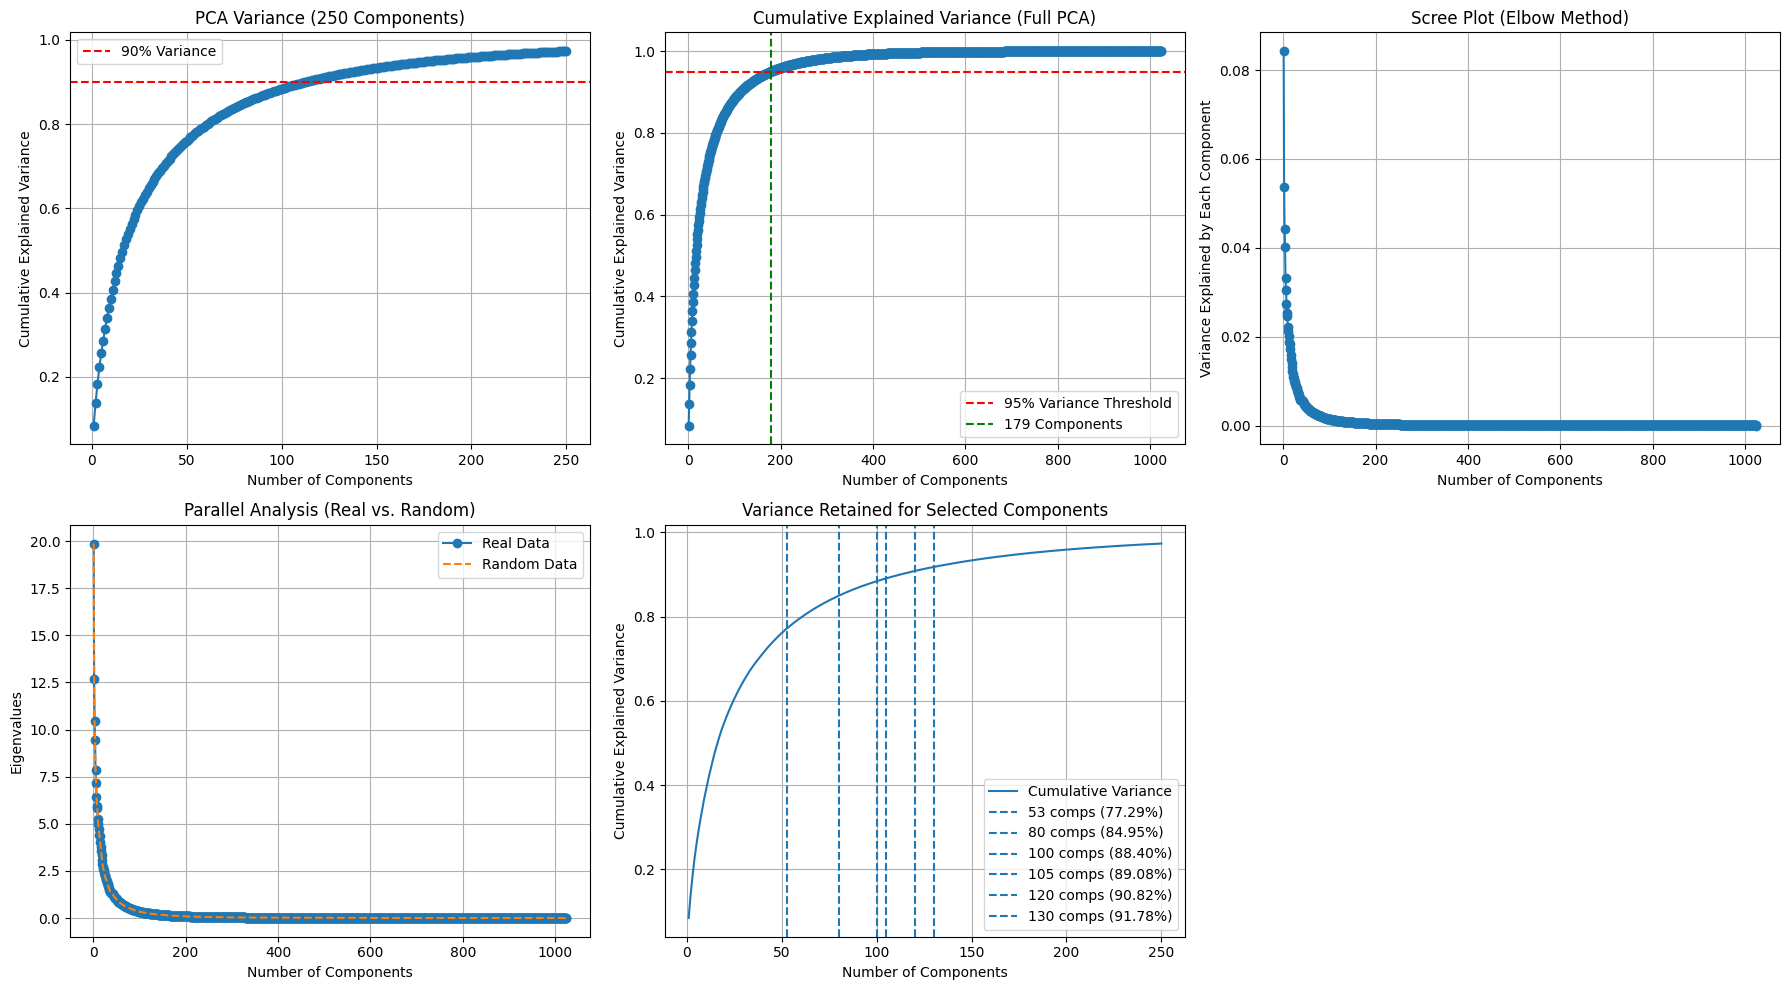

Number of components to retain 95% variance: 179
Number of components with eigenvalue > 1: 49
Number of components based on Parallel Analysis: 453
Variance retained for choices: {53: np.float32(0.77287066), 80: np.float32(0.84947413), 100: np.float32(0.8839637), 105: np.float32(0.8907863), 120: np.float32(0.9082285), 130: np.float32(0.9178299)}


In [10]:
features_pca_250, pca_obj_250 = perform_pca(embeddings, n_components=250)

# Fit PCA on the full dataset (all components) for additional analyses
pca_full = PCA()
pca_full.fit(embeddings)
explained_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(explained_variance_ratio >= 0.95) + 1  # Components needed for 95% variance

# Scree plot data and eigenvalue analysis
scree_values = pca_full.explained_variance_ratio_
eigenvalues = pca_full.explained_variance_
n_components_eigen = np.sum(eigenvalues > 1)

# Parallel Analysis: Compare PCA on real data vs. shuffled (random) data
X_random = shuffle(embeddings, random_state=RANDOM_STATE)
pca_real = PCA().fit(embeddings)
pca_random = PCA().fit(X_random)
n_components_parallel = np.sum(pca_real.explained_variance_ > pca_random.explained_variance_)

# Compare specific component choices by fitting PCA with 250 components
pca_250 = PCA(n_components=250).fit(embeddings)
explained_variance_cum = np.cumsum(pca_250.explained_variance_ratio_)
choices = [53, 80, 100, 105, 120, 130]
variance_retained = {n: explained_variance_cum[n - 1] for n in choices}

# Create a grid of subplots for the various plots
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

# Plot 1: Cumulative Variance for PCA with 250 components
plot_pca_variance(axs[0], pca_obj_250, title='PCA Variance (250 Components)', threshold=0.90)

# Plot 2: Cumulative Explained Variance (Full PCA) with 95% threshold indicator
axs[1].plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
axs[1].axhline(y=0.95, color='r', linestyle='--', label="95% Variance Threshold")
axs[1].axvline(x=n_components_95, color='g', linestyle='--', label=f"{n_components_95} Components")
axs[1].set_xlabel("Number of Components")
axs[1].set_ylabel("Cumulative Explained Variance")
axs[1].legend()
axs[1].grid(True)
axs[1].set_title("Cumulative Explained Variance (Full PCA)")

# Plot 3: Scree Plot (Variance Explained by Each Component)
axs[2].plot(range(1, len(scree_values) + 1), scree_values, marker='o')
axs[2].set_xlabel("Number of Components")
axs[2].set_ylabel("Variance Explained by Each Component")
axs[2].set_title("Scree Plot (Elbow Method)")
axs[2].grid(True)

# Plot 4: Parallel Analysis (Real Data vs. Random Data)
axs[3].plot(range(1, len(pca_real.explained_variance_) + 1), pca_real.explained_variance_, 
            label="Real Data", marker='o')
axs[3].plot(range(1, len(pca_random.explained_variance_) + 1), pca_random.explained_variance_, 
            label="Random Data", linestyle="dashed")
axs[3].set_xlabel("Number of Components")
axs[3].set_ylabel("Eigenvalues")
axs[3].legend()
axs[3].grid(True)
axs[3].set_title("Parallel Analysis (Real vs. Random)")

# Plot 5: Cumulative Variance with Vertical Lines for Selected Component Choices
axs[4].plot(range(1, len(explained_variance_cum) + 1), explained_variance_cum, label="Cumulative Variance")
for n in choices:
    axs[4].axvline(n, linestyle="--", label=f"{n} comps ({variance_retained[n]:.2%})")
axs[4].set_xlabel("Number of Components")
axs[4].set_ylabel("Cumulative Explained Variance")
axs[4].legend()
axs[4].grid(True)
axs[4].set_title("Variance Retained for Selected Components")

# Hide the unused subplot
axs[5].axis('off')

plt.tight_layout()
plt.show()

# Print out the key findings
print(f"Number of components to retain 95% variance: {n_components_95}")
print(f"Number of components with eigenvalue > 1: {n_components_eigen}")
print(f"Number of components based on Parallel Analysis: {n_components_parallel}")
print("Variance retained for choices:", variance_retained)

## PCA for Dimensionality Reduction

We apply PCA to the embeddings and plot the cumulative explained variance to show how many components are needed.

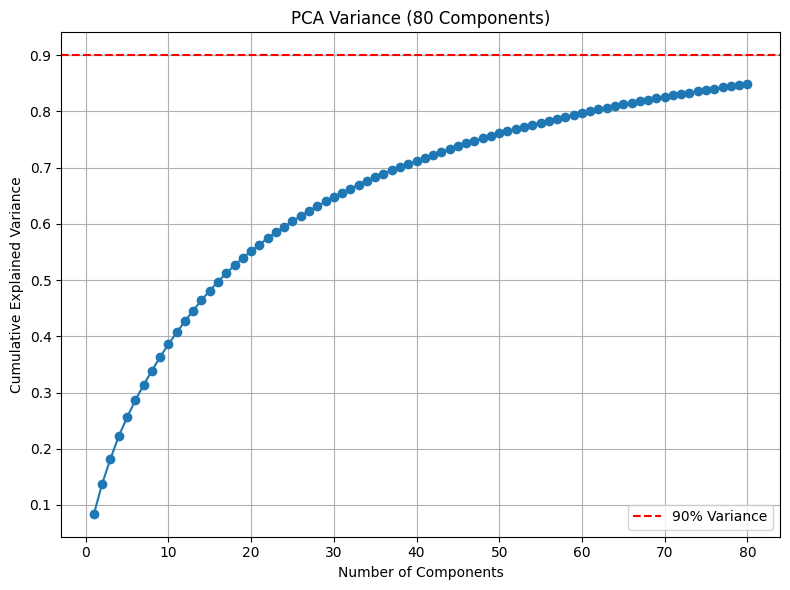

In [9]:
def perform_pca_80(features, n_components=80):
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    features_pca = pca.fit_transform(features)
    return features_pca, pca

def plot_pca_variance(ax, pca, title='PCA Explained Variance vs. Number of Components', threshold=0.90):
    cum_var = np.cumsum(pca.explained_variance_ratio_)
    ax.plot(range(1, len(cum_var)+1), cum_var, marker='o')
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Cumulative Explained Variance')
    ax.set_title(title)
    ax.axhline(y=threshold, color='r', linestyle='--', label=f'{int(threshold*100)}% Variance')
    ax.legend()
    ax.grid(True)

# Perform PCA using 80 components
features_pca_80, pca_obj_80 = perform_pca_80(embeddings, n_components=80)

# Plot the cumulative variance for 80 components
fig, ax = plt.subplots(figsize=(8,6))
plot_pca_variance(ax, pca_obj_80, title='PCA Variance (80 Components)', threshold=0.90)
plt.tight_layout()
plt.show()


### PCA Analysis Evaluation and Final Decision

After evaluating multiple metrics—including the cumulative explained variance, scree plot, eigenvalue analysis, and parallel analysis—the following insights were obtained:

- **95% Variance Threshold:** The analysis on full-dimensional PCA indicated that a larger number of components are needed to capture 95% of the variance.
- **Scree Plot & Eigenvalue Analysis:** These methods revealed a significant drop in variance explained after the initial components, with many later components having eigenvalues less than 1.
- **Parallel Analysis:** Comparing the eigenvalues from the real data against those from random data confirmed that many components in the full dataset contribute minimal unique information.
- **Comparison for Specific Component Counts:** When evaluating selected component counts (53, 80, 89, 96), the 80-component solution achieved a substantial retention of variance while avoiding unnecessary complexity.

**Final Decision:** We have chosen **80 components** as the optimal balance between dimensionality reduction and preserving the integrity of the data. This choice improves model efficiency and reduces noise without sacrificing key information.


In [7]:
final_model = joblib.load("models/xgboost_final_model.pkl")
X_test = joblib.load("models/X_test.pkl")
y_test = joblib.load("models/y_test.pkl")

y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

print("Final Test Metrics:")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.2f}")
print("")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=2))

Final Test Metrics:
AUC-ROC: 0.77
Accuracy: 0.71
F1 Score: 0.67

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.46      0.56     16225
           1       0.72      0.88      0.79     25308

    accuracy                           0.71     41533
   macro avg       0.71      0.67      0.67     41533
weighted avg       0.71      0.71      0.70     41533

